In [105]:
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import torch

from torch import nn
from torchvision import transforms
from scripts import data_setup, engine, utils
import torchinfo

In [106]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
data_path = Path("data/")
image_path = data_path / "soil_images_sorted"

In [108]:
# Get a set of pretrained model weights
weights = torchvision.models.ResNeXt101_64X4D_Weights.DEFAULT
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [109]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [110]:
#HyperParameters
batch_Size = 5
learning_rate = 0.001
epochS = 10
dropout_prob = 0.2

In [111]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=batch_Size)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x21343b56810>,
 ['high', 'low', 'medium'])

In [112]:
model = torchvision.models.resnext101_64x4d(weights=weights).to(device)

In [113]:
# for param in model.parameters():
#     param.requires_grad = False

# for name, child in model.named_children():
#     if name in ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4']:
#         for param in child.parameters():
#             param.requires_grad = False

In [114]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_prob, inplace=True), 
    nn.Linear(in_features=9216, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [115]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [116]:

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:21<03:15, 21.73s/it]

Epoch: 1 | train_loss: 3.6711 | train_acc: 0.4235 | test_loss: 2.8457 | test_acc: 0.5200


 20%|██        | 2/10 [00:43<02:54, 21.79s/it]

Epoch: 2 | train_loss: 0.7963 | train_acc: 0.7147 | test_loss: 0.8736 | test_acc: 0.6000


 30%|███       | 3/10 [01:05<02:31, 21.66s/it]

Epoch: 3 | train_loss: 0.5155 | train_acc: 0.8324 | test_loss: 0.5296 | test_acc: 0.7600


 40%|████      | 4/10 [01:26<02:09, 21.65s/it]

Epoch: 4 | train_loss: 0.3530 | train_acc: 0.8824 | test_loss: 0.8945 | test_acc: 0.8400


 50%|█████     | 5/10 [01:47<01:46, 21.34s/it]

Epoch: 5 | train_loss: 0.3174 | train_acc: 0.9176 | test_loss: 0.5730 | test_acc: 0.8400


 60%|██████    | 6/10 [02:07<01:24, 21.01s/it]

Epoch: 6 | train_loss: 0.2212 | train_acc: 0.8941 | test_loss: 0.5009 | test_acc: 0.8400


 70%|███████   | 7/10 [02:26<01:01, 20.37s/it]

Epoch: 7 | train_loss: 0.2431 | train_acc: 0.9059 | test_loss: 0.6502 | test_acc: 0.7600


 80%|████████  | 8/10 [02:46<00:40, 20.02s/it]

Epoch: 8 | train_loss: 0.3427 | train_acc: 0.8912 | test_loss: 1.2658 | test_acc: 0.7400


 90%|█████████ | 9/10 [03:05<00:19, 19.74s/it]

Epoch: 9 | train_loss: 0.1281 | train_acc: 0.9765 | test_loss: 0.4615 | test_acc: 0.9200


100%|██████████| 10/10 [03:24<00:00, 20.45s/it]

Epoch: 10 | train_loss: 0.1304 | train_acc: 0.9588 | test_loss: 0.4110 | test_acc: 0.8400
[INFO] Total training time: 204.544 seconds


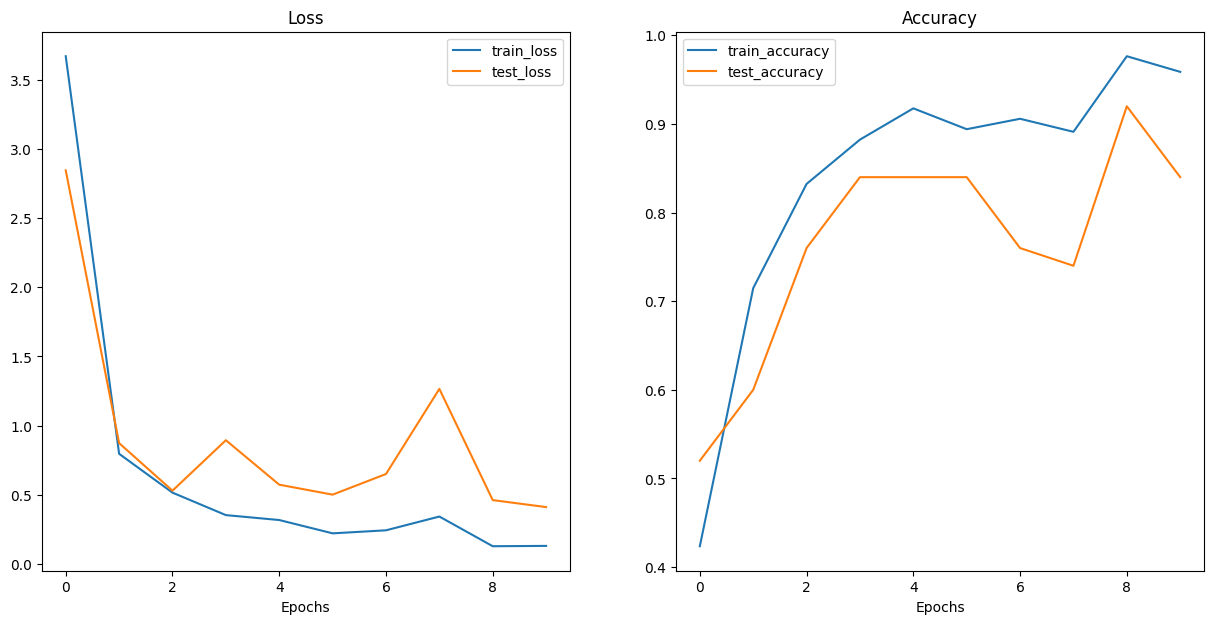

In [117]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)

In [118]:
from winsound import Beep
Beep(300, 200)

In [120]:
utils.save_model(model=model,
                 target_dir="models",
                 model_name="ResNext_1.pth")

[INFO] Saving model to: models\ResNext_1.pth
